# Classification Example
Latent Dimensionality Reduction applied to the [Wisconsin breat cancer data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

Useful because of the ability to backtrack from a model, and identify what metrics are significant indicators of issues.

In [36]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.neighbors import KernelDensity
from sklearn import tree

from ldr import LDR

In [2]:
np.random.seed(42)

In [3]:
plt.style.use("illumina.mplstyle")

In [4]:
WRITE_PATH = "write_up/img/"

## Data Generation

In [5]:
scale = 6

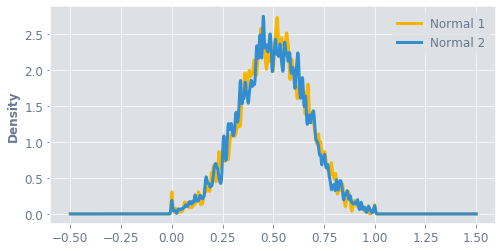

In [27]:
df = pd.DataFrame({
    "Normal 1": pd.Series(np.random.normal(0.5, 1/scale, 5000)),
    "Normal 2": pd.Series(np.random.normal(0.5, 1/scale, 5000))
})

df = df.clip(lower=0, upper=1)

bandwidth = 0.02
df["Normal 1"].plot.kde(figsize=(8, 4), bw_method=bandwidth, legend=True)
df["Normal 2"].plot.kde(bw_method=bandwidth, legend=True)
plt.savefig(WRITE_PATH + "gen_kde.png")

In [7]:
targets = df.apply(
    lambda row: 0 if (row["Normal 1"] < 0.5) else 1,
#     lambda row: (row["norm"], row["expo"]),
    axis=1
)

In [8]:
targets.value_counts()

1    2526
0    2474
dtype: int64

In [9]:
ldr = LDR(df, targets, "class", 1, 0)

Class balance fixed, Negatives: 2526 , Positives: 2526


In [10]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    ldr.scaled, ldr.targets, test_size=0.3, random_state=42)

## Classifier Training and Analysis

### Random Forests

In [39]:
rf_clf = tree.DecisionTreeClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))

Accuracy: 1.0


In [29]:
def rf_clf_func(df):
    proba = rf_clf.predict_proba(df)
    return np.array([i[1] for i in proba])

TL: [(1, 1)]
BR: []
LR: [(0, 1)]
TR: [(1, 0)]
1 1
Normal 1 Normal 2


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


1 0
Normal 1
0 1
Normal 2


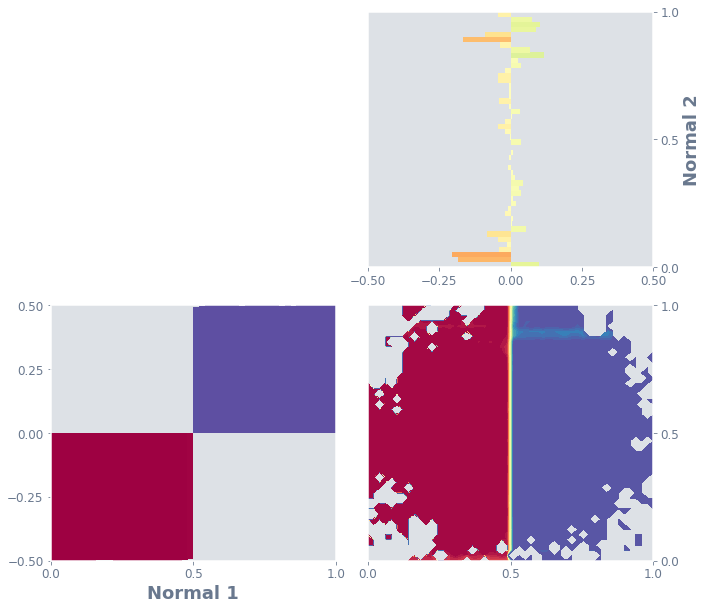

In [13]:
ldr.density_estimate(rf_clf_func)
ldr.vis_2d(dots=False, save=WRITE_PATH + "gen_rf.png")

### Isolation Forest
Used for outlier detection/estimating a learning frontier.

In [14]:
oc_clf = IsolationForest(n_estimators=100, behaviour="new", contamination="auto").fit(X_train)

In [15]:
def oc_clf_func(df):
    pred = oc_clf.predict(df)
    return [(i + 1) / 2 for i in pred]

In [16]:
tst = oc_clf_func(X_train)
pd.Series(tst).value_counts()

1.0    2792
0.0     708
dtype: int64

TL: [(1, 1)]
BR: []
LR: [(0, 1)]
TR: [(1, 0)]
1 1
Normal 1 Normal 2
1 0
Normal 1
0 1
Normal 2


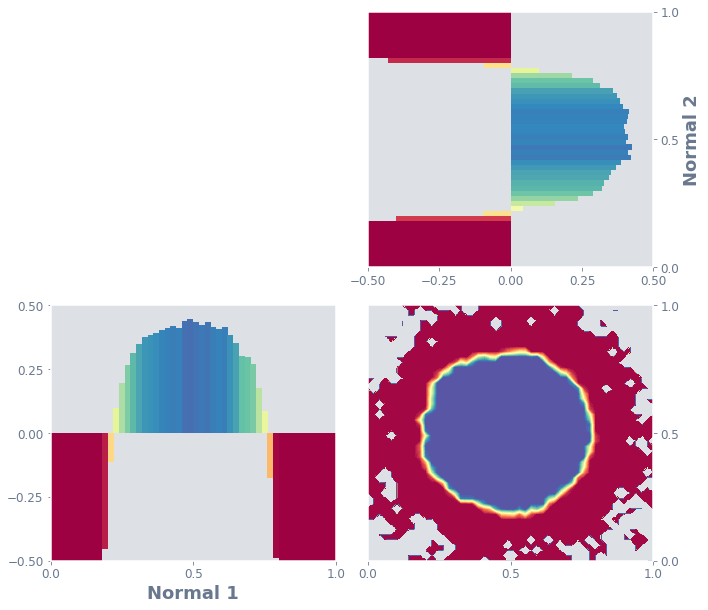

In [17]:
ldr.density_estimate(oc_clf_func)
ldr.vis_2d(dots=False, save=WRITE_PATH + "gen_if.png")

## Random Forest Classifier and Outlier Detection Superposition

In [18]:
def oc_rf_clf_func(df):
    oc_pred = oc_clf_func(df)
    rf_pred = rf_clf_func(df)
    return [(rf_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [19]:
tst = oc_rf_clf_func(X_train[:30])
print(tst[:30])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.5, 0.5, 0.5, 0.0, 0.010000000000000009, 0.0, 0.5]


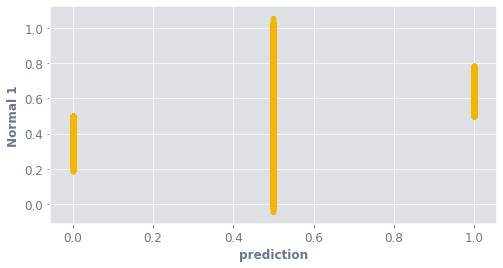

TL: [(1, 1)]
BR: []
LR: [(0, 1)]
TR: [(1, 0)]
1 1
Normal 1 Normal 2
1 0
Normal 1
0 1
Normal 2


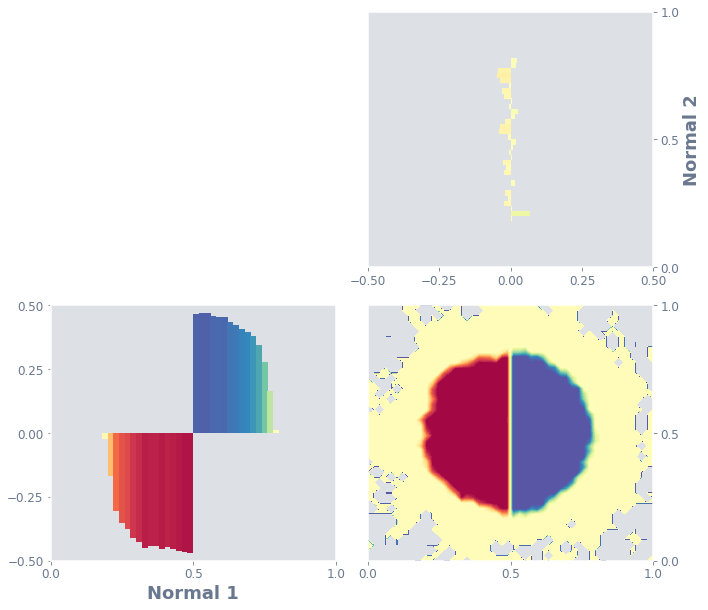

In [40]:
ldr.density_estimate(oc_rf_clf_func)
ldr.density_scatter("Normal 1", save=WRITE_PATH + "gen_rf_normal_1.png")
ldr.vis_2d(dots=False, save=WRITE_PATH + "gen_rf_if.png")

## Inspect Raw Predictions

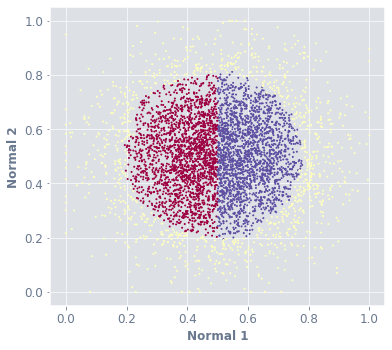

In [45]:
Spectral = plt.get_cmap("Spectral")
colors = Spectral(oc_rf_clf_func(df))
df.plot.scatter(x="Normal 1", y="Normal 2", c=colors, figsize=(6, 5.5), s=1)
plt.savefig(WRITE_PATH + "gen_scat.png")